In [1]:
import yfinance as yf
from datetime import date
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [31]:
df = pd.read_excel("Donnees_Bloomberg_Daily.xlsx")

df.index=df['Date']
del df['Date']

df=df.dropna()

df

,Bloomberg Barclays Global Aggregate Bond,Bloomberg Barclays Emerging Markets USD Aggregate,Bloomberg Commodity Index,Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD,Bloomberg Barclays Pan-European High Yield Hedged to USD,Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD,Bloomberg Barclays US Corporate,Bloomberg Barclays US Corporate High Yield,Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years
Date,,,,,,,,,
2000-01-31,209.9137,231.7258,147.8610,100.21,113.14,275.6170,995.43,546.93,110.098
2000-02-29,209.5158,243.1049,150.4460,101.16,114.67,276.6531,1004.66,547.99,110.522
2000-03-31,213.7084,249.8806,151.9040,102.52,114.38,281.5288,1013.22,536.47,113.565
2000-04-28,208.4867,246.1373,150.0390,102.70,114.84,282.8017,1004.33,537.33,114.718
2000-05-31,209.4520,240.2646,160.1370,102.56,111.47,285.8669,1000.58,531.82,114.478
...,...,...,...,...,...,...,...,...,...
2021-12-27,532.0166,1264.7040,214.3779,295.98,517.22,819.2017,3520.81,2461.96,389.891
2021-12-28,531.8620,1265.4540,213.6978,295.97,517.32,819.3927,3518.94,2463.02,389.891
2021-12-29,531.1477,1264.3740,213.9740,295.25,517.24,817.3085,3504.71,2461.94,389.647


In [32]:
#data.dropna(inplace = True)
#for i in range(len()) :
#    data.iloc[:,i] = data.iloc[:,i].pct_change()
#data

for col in df.columns:
    df[col]=df[col].pct_change()
    
df=df[1:]
df

,Bloomberg Barclays Global Aggregate Bond,Bloomberg Barclays Emerging Markets USD Aggregate,Bloomberg Commodity Index,Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD,Bloomberg Barclays Pan-European High Yield Hedged to USD,Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD,Bloomberg Barclays US Corporate,Bloomberg Barclays US Corporate High Yield,Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years
Date,,,,,,,,,
2000-02-29,-0.001896,0.049106,0.017483,0.009480,0.013523,0.003759,0.009272,0.001938,0.003851
2000-03-31,0.020011,0.027872,0.009691,0.013444,-0.002529,0.017624,0.008520,-0.021022,0.027533
2000-04-28,-0.024434,-0.014980,-0.012277,0.001756,0.004022,0.004521,-0.008774,0.001603,0.010153
2000-05-31,0.004630,-0.023859,0.067303,-0.001363,-0.029345,0.010839,-0.003734,-0.010254,-0.002092
2000-06-30,0.025354,0.043696,0.023599,0.004485,0.006011,0.005828,0.025115,0.020364,0.011452
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000476,0.000902,0.014942,0.000068,0.000755,0.000252,0.002411,0.002419,0.004043
2021-12-28,-0.000291,0.000593,-0.003172,-0.000034,0.000193,0.000233,-0.000531,0.000431,0.000000
2021-12-29,-0.001343,-0.000853,0.001292,-0.002433,-0.000155,-0.002544,-0.004044,-0.000438,-0.000626


In [37]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

# Split the data into training and testing sets
train_data = df[:split_index]
test_data = df[split_index:]

print(train_data.size)
print(test_data.size)

35658
8919


In [39]:
model = hmm.GaussianHMM(n_components=3, covariance_type='full',n_iter = 1000, random_state = 1000)
model.fit(train_data)

C:\Users\Guilhem\anaconda3\lib\site-packages\sklearn\utils\validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


GaussianHMM(covariance_type='full', n_components=3, n_iter=1000,
            random_state=1000)

In [40]:
states = model.predict(test_data)

C:\Users\Guilhem\anaconda3\lib\site-packages\sklearn\utils\validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


<AxesSubplot:>

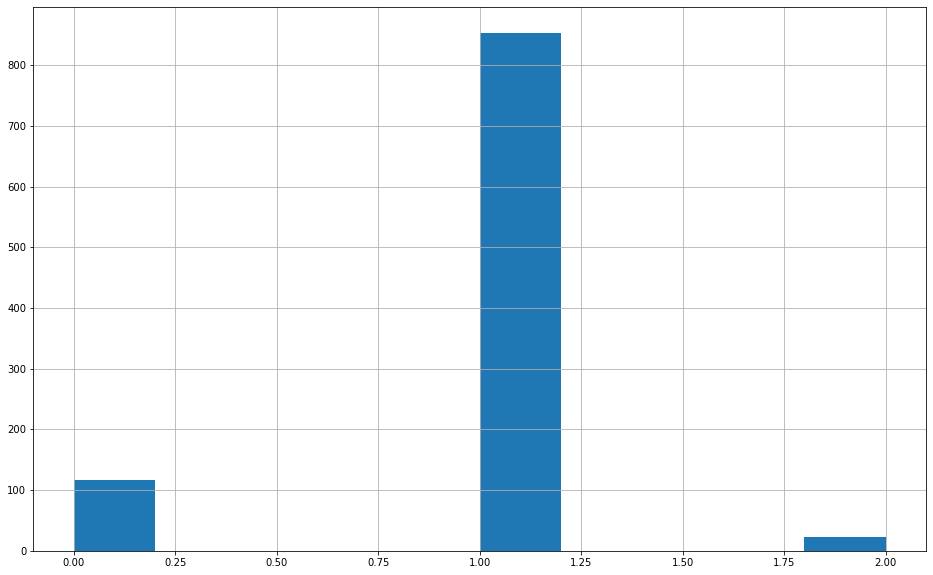

In [42]:
pd.Series(states).hist()

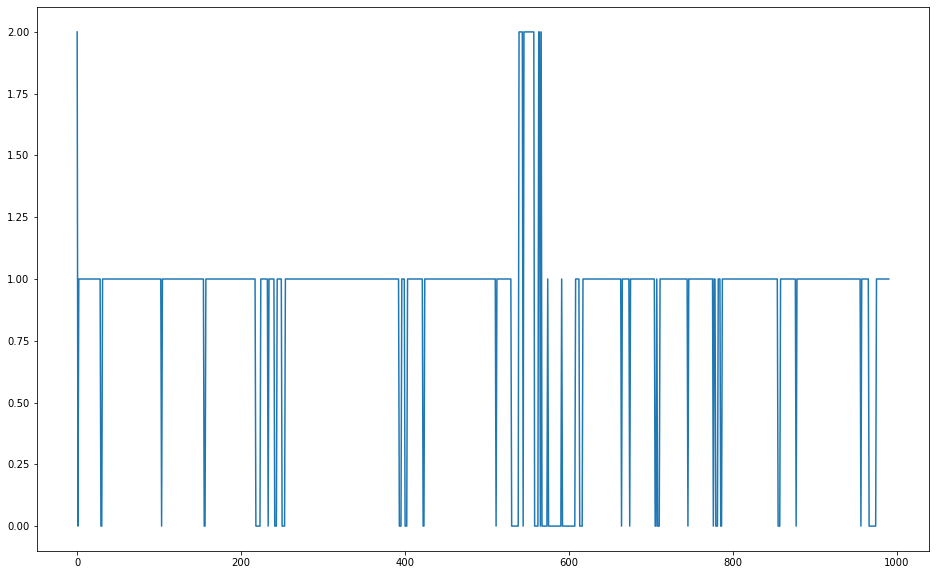

In [44]:
plt.plot(states)

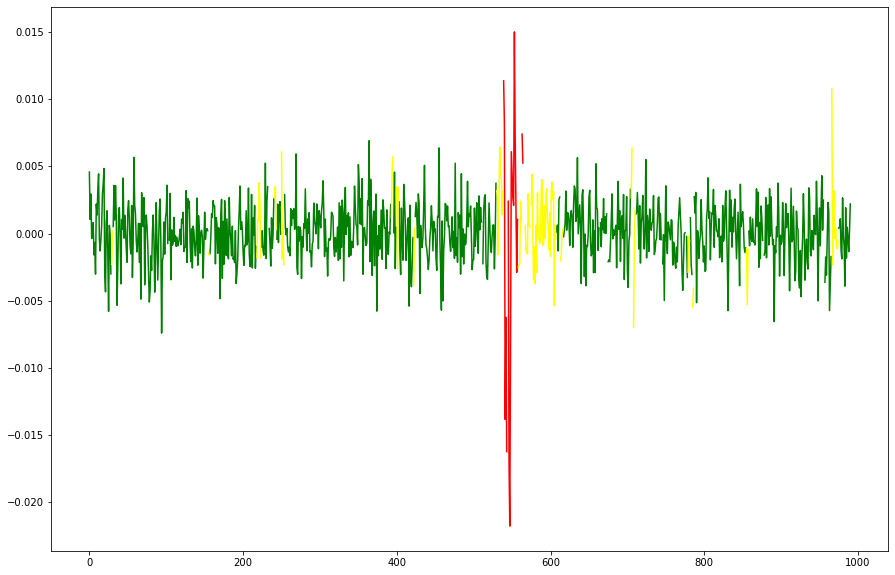

In [16]:
state1,state2,state3,state4 = [],[],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(reindexed_test_data['Bloomberg Barclays Global Aggregate Bond'][i])
    state2.append(float('nan'))
    state3.append(float('nan'))
    state4.append(float('nan'))
  if state == 1:
    state2.append(reindexed_test_data['Bloomberg Barclays Global Aggregate Bond'][i])
    state1.append(float('nan'))
    state3.append(float('nan'))
    state4.append(float('nan'))
  if state == 2:
    state3.append(reindexed_test_data['Bloomberg Barclays Global Aggregate Bond'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
    state4.append(float('nan'))
  if state == 3:
    state4.append(reindexed_test_data['Bloomberg Barclays Global Aggregate Bond'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
    state3.append(float('nan'))
  i += 1
plt.figure(figsize=(15,10))
plt.plot(state1,color='red')
plt.plot(state2,color='green')
plt.plot(state3,color='yellow')

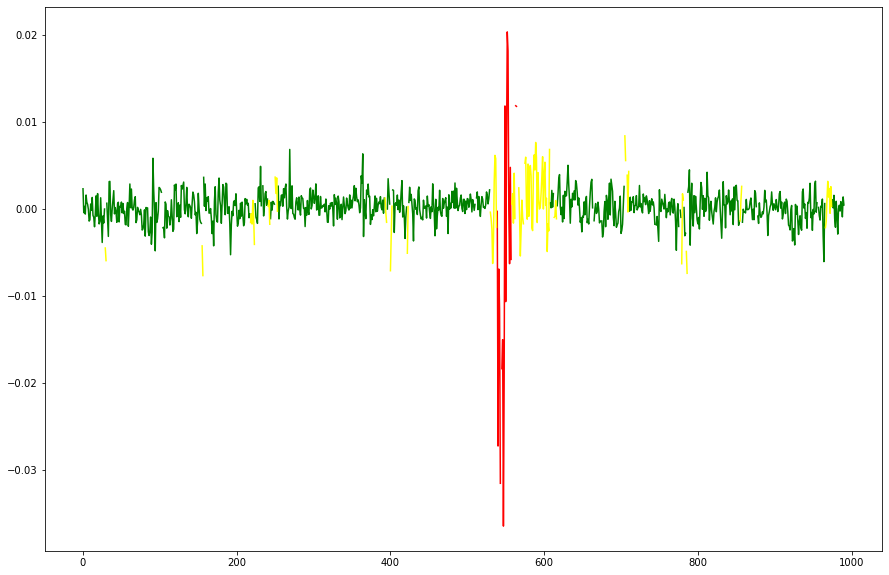

In [17]:
state1,state2,state3 = [],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(reindexed_test_data['Bloomberg Barclays Emerging Markets USD Aggregate'][i])
    state2.append(float('nan'))
    state3.append(float('nan'))
  if state == 1:
    state2.append(reindexed_test_data['Bloomberg Barclays Emerging Markets USD Aggregate'][i])
    state1.append(float('nan'))
    state3.append(float('nan'))
  if state == 2:
    state3.append(reindexed_test_data['Bloomberg Barclays Emerging Markets USD Aggregate'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
  i += 1
plt.figure(figsize=(15,10))
plt.plot(state1,color='red')
plt.plot(state2,color='green')
plt.plot(state3,color='yellow')

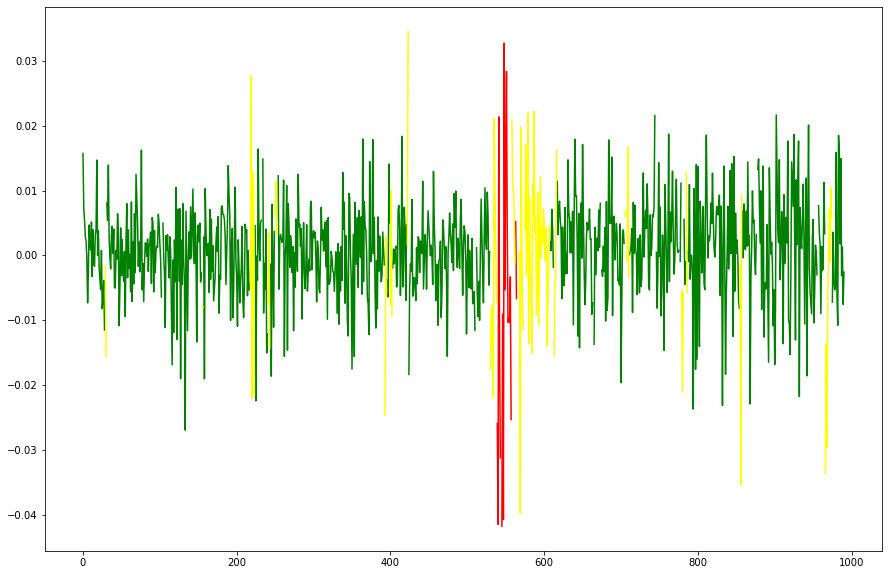

In [18]:
state1,state2,state3 = [],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(reindexed_test_data['Bloomberg Commodity Index'][i])
    state2.append(float('nan'))
    state3.append(float('nan'))
  if state == 1:
    state2.append(reindexed_test_data['Bloomberg Commodity Index'][i])
    state1.append(float('nan'))
    state3.append(float('nan'))
  if state == 2:
    state3.append(reindexed_test_data['Bloomberg Commodity Index'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
  i += 1
plt.figure(figsize=(15,10))
plt.plot(state1,color='red')
plt.plot(state2,color='green')
plt.plot(state3,color='yellow')

In [46]:
print("\nStart probabilities:")
print(model.startprob_)


Start probabilities:
[0. 0. 1.]


In [47]:
print("\nTransition matrix:")
print(model.transmat_)


Transition matrix:
[[7.41245285e-01 2.20332336e-01 3.84223790e-02]
 [1.04239144e-01 8.95756577e-01 4.27871822e-06]
 [2.95110840e-01 3.69625659e-15 7.04889160e-01]]


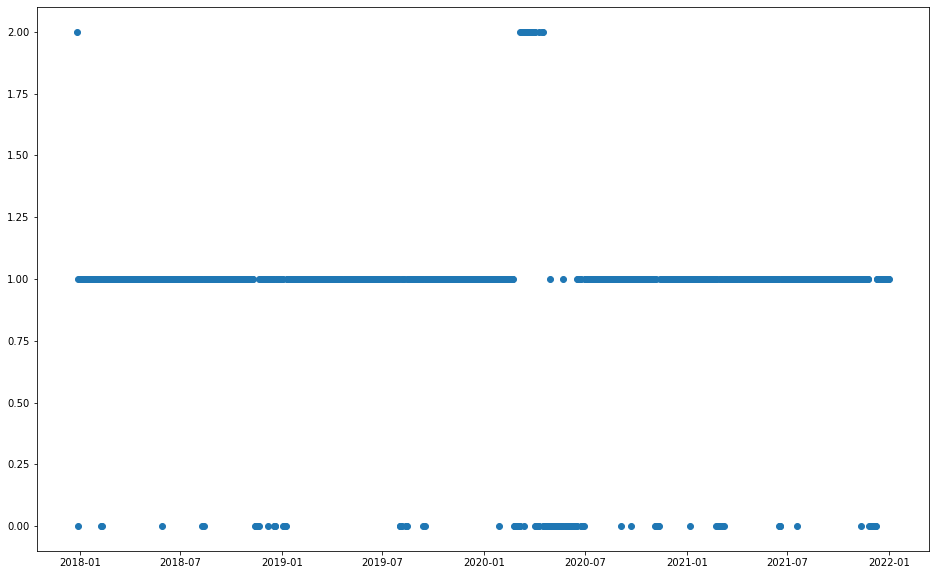

In [51]:
plt.scatter(test_data.index,states)

In [53]:
'''
Dataframe avec en colonne les proba d'état 1,2,3 et en ligne les dates 

'''
mat_trans=model.transmat_
mat_trans

array([[7.41245285e-01, 2.20332336e-01, 3.84223790e-02],
       [1.04239144e-01, 8.95756577e-01, 4.27871822e-06],
       [2.95110840e-01, 3.69625659e-15, 7.04889160e-01]])

In [69]:
test_df=np.column_stack((test_data,states))
cols=[]
for i in range(len(df.columns)):
    cols.append(df.columns[i])
cols.append('States')

test_df=pd.DataFrame(test_df,index=test_data.index,columns=cols)
test_df

,Bloomberg Barclays Global Aggregate Bond,Bloomberg Barclays Emerging Markets USD Aggregate,Bloomberg Commodity Index,Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD,Bloomberg Barclays Pan-European High Yield Hedged to USD,Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD,Bloomberg Barclays US Corporate,Bloomberg Barclays US Corporate High Yield,Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years,States
Date,,,,,,,,,,
2017-12-27,0.004581,0.002377,0.015708,0.002245,0.001004,0.002035,0.006393,0.001172,0.005795,2.0
2017-12-28,0.001061,-0.000368,0.007190,-0.001493,-0.000048,-0.001404,-0.000673,0.000513,-0.000119,0.0
2017-12-29,0.002952,0.000352,0.005392,0.000472,0.000382,-0.000075,0.001463,0.000441,0.002970,1.0
2018-01-02,-0.000361,-0.000532,0.002913,-0.001495,0.001217,-0.002380,-0.004490,0.000959,-0.002590,1.0
2018-01-03,0.000144,0.001658,0.002284,0.002285,0.002146,0.001197,0.001603,0.002598,0.000992,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000476,0.000902,0.014942,0.000068,0.000755,0.000252,0.002411,0.002419,0.004043,1.0
2021-12-28,-0.000291,0.000593,-0.003172,-0.000034,0.000193,0.000233,-0.000531,0.000431,0.000000,1.0
2021-12-29,-0.001343,-0.000853,0.001292,-0.002433,-0.000155,-0.002544,-0.004044,-0.000438,-0.000626,1.0


In [72]:
for date in test_df.index:
   print(mat_trans[int(test_df['States'].loc[date])])

[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[0.74124528 0.22033234 0.03842238]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.9575657

[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-

[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[0.74124528 0.22033234 0.03842238]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e-15 7.04889160e-01]
[2.95110840e-01 3.69625659e

[0.74124528 0.22033234 0.03842238]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[0.74124528 0.22033234 0.03842238]
[0.74124528 0.22033234 0.03842238]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871822e-06]
[1.04239144e-01 8.95756577e-01 4.27871